In [1]:
# in case there are any problems with importing because path is wrong
import sys
sys.path.append('C:/Users/nerpa\Dropbox (Personal)\Research\discrete_sr\code\python\SPIDER_discrete')

In [2]:
import numpy as np

from commons.weight import *
from utils import save, load
from library import *
from process_library_terms import *

In [3]:
import netCDF4 as nc

dataset = 'viscek/dt=1_rho=1_v=0.5_alpha=0.25_eta=0.35_N=100000.nc'
#dataset = 'viscek/dt=1_rho=1_v=0.5_alpha=0.25_eta=0.2_N=100000.nc'
#dataset = 'viscek/dt=1_rho=1_v=0.5_alpha=0.25_eta=0.15_N=100000.nc'
ds = nc.Dataset(dataset)
print(ds)

nt = len(ds.dimensions["time"])
n_particles = len(ds.dimensions["director"])
deltat = 1
v = 0.5
positions = np.array(ds.variables["position"]).T
positions = np.reshape(positions, (n_particles, 2, nt))
positions -= np.min(positions[:]) # recenter positions to [0, L]
directors = np.array(ds.variables["director"])
vs = v*np.stack([np.cos(directors), np.sin(directors)], axis=1).T
print(directors.shape)
print(positions.shape)
print(vs.shape)
dims = [np.max(positions[:]), nt]
world_size = np.array([dims[0], dims[0], dims[1]])
print(world_size)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    dimensions(sizes): Nv(100000), dof(200000), boxdim(4), unit(1), time(50), position(200000), director(100000)
    variables(dimensions): float32 time(time), float32 position(time, position), float32 director(time, director)
    groups: 
(50, 100000)
(100000, 2, 50)
(100000, 2, 50)
[316.22763062 316.22763062  50.        ]


In [ ]:
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
plt.rcParams['animation.ffmpeg_path'] = 'C:/Users/nerpa/Downloads/ffmpeg-6.0-essentials_build/bin/ffmpeg.exe'

vid_file = 'viscek/eta0.35.mp4'

fig, ax = plt.subplots(figsize=(6, 6))
qv = ax.quiver(positions[:, 0, -1], positions[:, 1, -1], 1, 0, clim=[-np.pi, np.pi])

def animate(i):
    if i % 10 == 0:
        print(i)
    qv.set_offsets(positions[:, :, i])
    norms = np.sqrt(vs[:, 0, i] ** 2 + vs[:, 1, i] ** 2)
    qv.set_UVC(vs[:, 0, i] / norms, vs[:, 1, i] / norms, np.angle(vs[:, 0, i] + 1.0j * vs[:, 1, i]))
    return qv,

anim = FuncAnimation(fig, animate, np.arange(0, positions.shape[-1]), interval=1, blit=True)
FFwriter = animation.FFMpegWriter(fps=24, codec="libx264")
anim.save(vid_file, writer=FFwriter, dpi=100)

(100000, 2, 491)


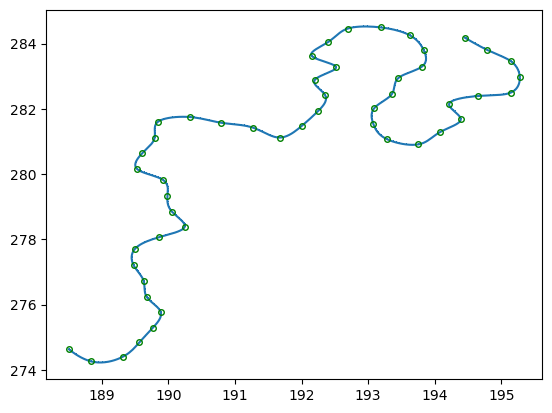

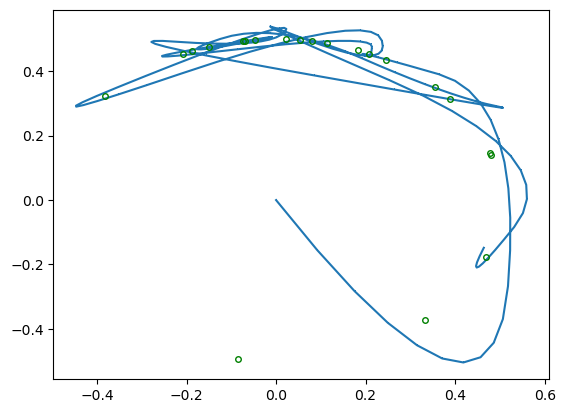

[188.5058136  188.8394165  189.31762695 189.56222534 189.76953125
 189.88319397 189.67445374 189.62771606 189.47683716 189.49914551] [188.50581 188.83942 189.31763 189.56223 189.76953 189.8832  189.67445
 189.62772 189.47684 189.49915]
 

         64034110 function calls (64016150 primitive calls) in 145.279 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   300000   24.013    0.000   24.274    0.000 _bsplines.py:469(_evaluate)
   200000   14.597    0.000   80.955    0.000 _bsplines.py:1093(make_interp_spline)
   800000    8.215    0.000   12.370    0.000 numerictypes.py:575(_can_coerce_all)
2605251/2604388    7.558    0.000   29.812    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
  1603605    7.224    0.000    7.224    0.000 {method 'reduce' of 'numpy.ufunc' objects}
   400000    6.068    0.000   30.103    0.000 index_tricks.py:323(__getitem__)
        2    3.757    1.878    3.757    1.878 {built-in method _pickle.dump}
   600000    3.605    0.000   12.944    0.000 _bsplines.py:27(_as_float_array)
  5600000    3.316    0.000    3.316    0.000 numerictypes.py:584(<listcomp>)
   200000    2.927    0.000    2.927    0.000 {scip

In [4]:
%%prun # profiling

from interp import *

### computational effort can be cut down by only interpolating at domain locations, 
### but on the other hand the current way allows interpolation to be one and done
interp_factor = 10 #10x interpolation of data on intermediate times
old_pos = positions
old_vs = vs
positions, psplines = interp(positions, interp_factor, k=3)
vs, vsplines = interp(vs, interp_factor, k=3)
# overwrite vs using derivative of psplines (optional, not sure this is at all a good idea)
eval_pts = np.linspace(0, 1, num=positions.shape[-1])
derivative_vsplines = [spline.derivative() for spline in psplines]
derivative_vs_list = [vspline(eval_pts) for vspline in derivative_vsplines]
vs = np.transpose(np.dstack(derivative_vs_list))/(world_size[-1]-1) # normalization of e.g. [0, 49] to [0, 1]

deltat /= interp_factor
world_size[-1] = (world_size[-1]-1)*interp_factor+1

print(positions.shape)
plot_interp(old_pos[0, :, :], positions[0, :, :])
plot_interp(old_vs[0, :, :21], vs[0, :, :201])
print(positions[0, 0, 0:100:10], old_pos[0, 0, :10])
save('Q_XY_0.35_interp.npy', positions, vs, psplines, vsplines)

In [ ]:
%%prun # profiling

positions, vs = load('Q_XY_0.35_interp.npy', 2)

data_dict = {}
data_dict['v'] = vs
v_obs = Observable('v', 1)
observables = [v_obs]

# fix random seed
np.random.seed(1)

# initial setup of dataset
kernel_sigma = 2
cg_res = 1
srd = SRDataset(world_size, data_dict, positions, observables, 
                kernel_sigma=kernel_sigma, cg_res=cg_res, deltat=deltat, cutoff=6)

# initialize libraries, domains, and weights
#srd.make_libraries(max_complexity=4, max_observables=3)
#srd.make_libraries(max_complexity=5, max_observables=3)
srd.make_libraries(max_complexity=6, max_observables=4)

dom_width = 80
dom_time = 50 #previously 20 (without interpolation)
srd.make_domains(ndomains=15, domain_size=[dom_width, dom_width, dom_time], pad=kernel_sigma*8) #ndomains = 30
srd.make_weights(m=8, qmax=1)
corr_L = 5
srd.set_LT_scale(L=corr_L, T=corr_L/v) # note that this line must go before make_library_matrices
srd.make_library_matrices(debug=False)

save('Q_XY_0.35.npy', srd.dxs, srd.libs)

In [ ]:
_, libs = load('Q_XY_0.35.npy', 2)
libs = libs.item()

In [ ]:
from identify_models import *
opts = dict()
#opts['threshold'] = "AIC"
opts['threshold'] = "threshold"
#opts['row_norms'] = libs[0].row_weights
opts['method'] = "stepwise"
#opts['method'] = "power"
opts['gamma'] = 2
opts['delta'] = 1e-8#1e-8 # apparently this reaches machine precision as the relative error
opts['anchor_norm'] = np.linalg.norm(libs[0].Q[:, 0])
# note - in the case of higher harmonics we do not have residual = 1 for 1 = 0 as expected.
opts['verbose'] = False
opts['char_sizes'] = libs[0].col_weights#np.linalg.norm(libs[0].Q, axis=0)
opts1 = opts.copy()
opts1['char_sizes'] = libs[1].col_weights#np.linalg.norm(libs[1].Q, axis=0)
#opts1['row_norms'] = libs[1].row_weights

eqs, lambdas, derived_eqs, excluded_terms = interleave_identify([libs[0].Q, libs[1].Q], 
[opts, opts1], [libs[0].terms, libs[1].terms], threshold=1e-2) #1e-3 #1e-2

In [ ]:
import seaborn as sns
%matplotlib inline
sns.set(rc={'figure.figsize':(14,9)})

# calculate the correlation matrix
R2 = (np.corrcoef(libs[0].Q, rowvar=False)**2)
# plot the heatmap
label_names = [str(term) for term in libs[0].terms]
sns.heatmap(R2, xticklabels=label_names, yticklabels=label_names, annot=True, fmt=".2f")

In [ ]:
def visualize_cgp(srd, vid_file, n_cgp, n_domain, obs_dims=None):
    fig, ax = plt.subplots(figsize=(6, 6))
    cgp = srd.cgps[n_cgp]
    domain = srd.cgps[n_domain]
    if obs_dims is None:
        obs_dims = [0]*cgp.rank
    print(f"Visualizing {cgp} on domain {domain} using dimensions {obs_dims}")
    
    def animate(i):
        if i % 10 == 0:
            print(f"frame={i}")
        ax.imshow(srd.cg_dict[cgp, tuple(obs_dims), domain][i])
        return ax,

    anim = FuncAnimation(fig, animate, np.arange(0, len(domain.times)), interval=1, blit=True)
    FFwriter = animation.FFMpegWriter(fps=24, codec="libx264")
    anim.save(vid_file, writer=FFwriter, dpi=100)
    
visualize_cgp(srd, 'viscek/cg_rho_test.mp4', 0, 0)

In [ ]:
for i, term, size in zip(list(range(len(libs[0].terms))), libs[0].terms, libs[0].col_weights):
    print(i, term, size, term.complexity)
for i, term, size in zip(list(range(len(libs[1].terms))), libs[1].terms, libs[1].col_weights):
    print(i, term, size, term.complexity)

In [ ]:
continuity_terms = ['dt rho', 'dj rho[v_j]']
#continuity_terms = ['dt rho', 'dj rho[v_j]', 'dt^2 rho', 'dj^2 rho']

#continuity_terms = ['1', 'rho', 'rho * rho']
#continuity_terms = ['1']
#continuity_terms = ['rho * dt rho', 'rho * dj rho[v_j]']
#continuity_terms = ['dt rho * rho', 'rho * rho * dj v_j', 'dj rho * rho * v_j']
#continuity_terms = ['dt rho', 'dj rv_j']
col_numbers = [find_term(libs[0].terms, name) for name in continuity_terms]
Xi, lambd = regress(libs[0].Q, col_numbers, libs[0].col_weights, normalization=opts['anchor_norm'])
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {libs[0].terms[i]}. (Char. size: {libs[0].col_weights[i]})")
print("Model residual:", lambd)

In [ ]:
print(libs[0].Q[:10, 4], libs[0].Q[:10, 35])

In [ ]:
### plot strong-form fields

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from utils import construct_from_string

zero_arr = [0] * srd.n_dimensions
constant_weight = Weight(m=zero_arr, q=zero_arr, k=zero_arr) # should evaluate to 1 everywhere

def make_residual_arr(equation, domain, kc):
    arrs = [c*srd.make_tw_arr(term, constant_weight, [domain], kc, by_parts=False) 
            for term, c in zip(equation.term_list, equation.coeffs)]
    return sum(arrs)[..., 0]

domain = srd.domains[0]
kc = None # can select x, y components

term1 = srd.libs[0].terms[find_term(libs[0].terms, 'dt rho')]
tw_arr = srd.make_tw_arr(term1, constant_weight, [domain], kc, by_parts=False)
fig, (ax1, ax2) = plt.subplots(2, 1)
im = ax1.imshow(tw_arr[:, :, 0])
#colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

term2 = srd.libs[0].terms[find_term(libs[0].terms, 'dj rho[v_j]')]
tw_arr2 = srd.make_tw_arr(term2, constant_weight, [domain], kc, by_parts=False)
im = ax2.imshow(tw_arr2[:, :, 0])
#colorbar
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax2)

ax1.set_ylabel(str(term1))
ax2.set_ylabel(str(term2))

plt.show()

In [ ]:
constraint_terms = ['rho', 'rho[v_j * v_j]']
col_numbers = [find_term(libs[0].terms, name) for name in constraint_terms]
Xi, lambd = regress(libs[0].Q, col_numbers, libs[0].col_weights, normalization=opts['anchor_norm'])
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {libs[0].terms[i]}. (Char. size: {libs[0].col_weights[i]})")
print("Model residual:", lambd)

In [ ]:
wave_terms = ['dt^2 rho', 'dj^2 rho']
col_numbers = [find_term(libs[0].terms, name) for name in wave_terms]
Xi, lambd = regress(libs[0].Q, col_numbers, libs[0].col_weights, normalization=opts['anchor_norm'])
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {libs[0].terms[i]}. (Char. size: {libs[0].col_weights[i]})")
print("Model residual:", lambd)

In [ ]:
burger_terms = ['dt rho[v_i]', 'dj rho[v_i * v_j]']
#burger_terms = ['dt rho[v_i]', 'dj rho[v_i * v_j]', 'di rho']#, 'dj^2 rho[v_i]']# 'dj^2 rho[v_i]']
#burger_terms = ['dt rho[v_i]', 'rho * dj rho[v_i * v_j]', 'di rho']
col_numbers = [find_term(libs[1].terms, name) for name in burger_terms]
Xi, lambd = regress(libs[1].Q, col_numbers, libs[1].col_weights, normalization=opts['anchor_norm'])
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {libs[1].terms[i]}. (Char. size: {libs[1].col_weights[i]})")
print("Model residual:", lambd)

In [ ]:
#euler_terms = ['dt rho[v_i]', 'dj rho[v_i * v_j]', 'di rho']
euler_terms = ['dj rho[v_i * v_j]', 'di rho']
col_numbers = [find_term(libs[1].terms, name) for name in euler_terms]
Xi, lambd = regress(libs[1].Q, col_numbers, libs[1].col_weights, normalization=opts['anchor_norm'])
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {libs[1].terms[i]}. (Char. size: {libs[1].col_weights[i]})")
print("Model residual:", lambd)

In [ ]:
toner_tu_terms = ['dt rho[v_i]', 'dj rho[v_i * v_j]', 'rho[v_i] * dj rho[v_j]', 'rho[v_i]',
                'di rho', 'dj^2 rho[v_i]', 'di dj rho[v_j]']
#, 'dj dk rho[v_i * v_j * v_k]'], 'rho * di rho', 'rho * rho * di rho'
# third term is a bit sketchy
col_numbers = [find_term(libs[1].terms, name) for name in toner_tu_terms]
Xi, lambd = regress(libs[1].Q, col_numbers, libs[1].col_weights, normalization=opts['anchor_norm'])
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {libs[1].terms[i]}. (Char. size: {libs[1].col_weights[i]})")
print("Model residual:", lambd)

In [ ]:
0.03 (0.99998), 0.018, 0.12, 0.08